# Vision Transformer

## Import all necessary libraries

In [1]:
import os
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Layer,
    Dense, 
    Flatten,
    Add,
    Embedding,
    LayerNormalization,
    MultiHeadAttention,
)

%matplotlib inline

## Patch Encoder

In [2]:
test_image = cv2.imread("data/dog.jpg")
test_image = cv2.resize(test_image, (256, 256))
test_image = tf.expand_dims(test_image, axis=0)

Metal device set to: Apple M2


In [3]:
patches = tf.image.extract_patches(images=test_image,
                                   sizes=[1, 16, 16, 1],
                                   strides=[1, 16, 16, 1],
                                   rates=[1, 1, 1, 1],
                                   padding='VALID')

In [4]:
flattened_patches = tf.reshape(patches, (patches.shape[0], -1, 768))

In [5]:
print(patches.shape)
print(flattened_patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


### Show the patches

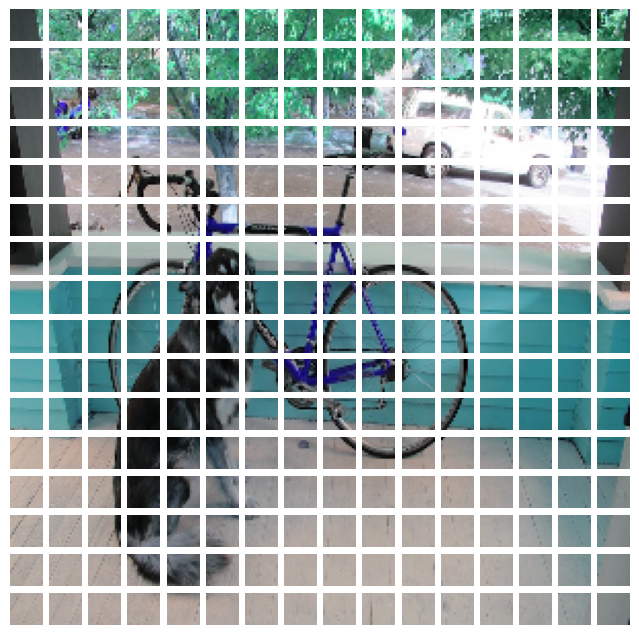

In [6]:
plt.figure(figsize=(8,8))
k = 0
for i in range(16):
    for j in range(16):
        ax = plt.subplot(16, 16, k+1)
        plt.imshow(tf.reshape(patches[0,i,j,:], (16,16,3)))
        plt.axis("off")
        k+=1

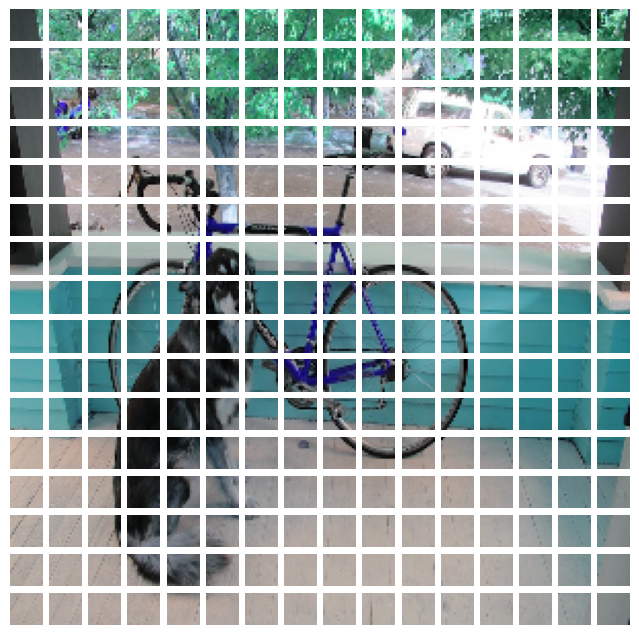

In [7]:
plt.figure(figsize=(8,8))
for i in range(flattened_patches.shape[1]):
        ax = plt.subplot(16, 16, i+1)
        plt.imshow(tf.reshape(flattened_patches[0,i,:], (16,16,3)))
        plt.axis("off")

## Vision Transformer (ViT)

### 1. PatchEncoder

In [8]:
class PatchEncoder(Layer):
    # embed_dim: hidden size
    def __init__(self, num_patches, embed_dim):
        super(PatchEncoder, self).__init__(name = 'patch_encoder')
        
        self.linear_projection = Dense(embed_dim)
        self.positional_embedding = Embedding(input_dim=num_patches, output_dim=embed_dim)
        self.n_patches = num_patches
    
    def call(self, x):
        patches = tf.image.extract_patches(images=x,
                                           sizes=[1, 16, 16, 1],
                                           strides=[1, 16, 16, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        flattened_patches = tf.reshape(patches, (patches.shape[0], -1, patches.shape[-1]))
        embedding_input = tf.range(0, self.n_patches, delta=1)
        output = self.linear_projection(flattened_patches) + self.positional_embedding(embedding_input)
        
        return output

In [9]:
patch_enc = PatchEncoder(256, 768)
print(patch_enc(tf.zeros([1,256,256,3])))

tf.Tensor(
[[[ 0.03757956  0.0087177   0.03695829 ...  0.04228142 -0.03038255
    0.04368183]
  [-0.01937617 -0.03970623 -0.00824863 ... -0.01799481  0.01187032
   -0.00315437]
  [-0.03546057 -0.00548474 -0.00865995 ...  0.00357256 -0.03259403
   -0.01895633]
  ...
  [-0.02045687  0.00868558 -0.03048771 ...  0.0044044  -0.01680114
    0.03817861]
  [ 0.02988461 -0.01704173  0.00403873 ...  0.0238487  -0.01862116
    0.02188525]
  [ 0.04831607  0.00529986  0.01757988 ... -0.02660987 -0.02555971
   -0.01254071]]], shape=(1, 256, 768), dtype=float32)


### 2. TransformerEncoder

In [10]:
class TransformerEncoder(Layer):
    # embed_dim: hidden size
    def __init__(self, num_heads, embed_dim):
        super(TransformerEncoder, self).__init__(name = 'transformer_encode')

        self.layer_norm_1 = LayerNormalization()
        self.layer_norm_2 = LayerNormalization()
        
        self.multi_head_attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim,
        )

        self.dense_1 = Dense(embed_dim, activation = tf.nn.gelu)
        self.dense_2 = Dense(embed_dim, activation = tf.nn.gelu)

    def call(self, input):
        x1 = self.layer_norm_1(input)
        x1 = self.multi_head_attention(x1, x1)

        x1 = Add()([x1, input])
        
        x2 = self.layer_norm_2(x1)
        x2 = self.dense_1(x2)
        output = self.dense_2(x2)

        output = Add()([output, x1])

        return output

In [11]:
trans_enc = TransformerEncoder(8, 768)
print(trans_enc(tf.zeros([1,256,768])))

tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]], shape=(1, 256, 768), dtype=float32)


### 3. ViT

In [12]:
class ViT(tf.keras.Model):
    # embed_dim: hidden size
    def __init__(self, num_layers, num_patches, embed_dim, num_heads, mlp_dim, num_class=10):
        super(ViT, self).__init__(name = 'vision_transformer')

        self.num_layers = num_layers
        self.patch_encoder = PatchEncoder(num_patches, embed_dim)
        self.trans_encoders = [TransformerEncoder(num_heads, embed_dim) for _ in range(self.num_layers)]
        self.dense_1 = Dense(mlp_dim, tf.nn.gelu)
        self.dense_2 = Dense(mlp_dim, tf.nn.gelu)
        self.dense_3 = Dense(num_class, activation='softmax')
    
    def call(self, input, training = True):
        x = self.patch_encoder(input)

        for i in range(self.num_layers):
            x = self.trans_encoders[i](x)

        x = Flatten()(x)
        x = self.dense_1(x)
        x = self.dense_2(x)

        return self.dense_3(x)

In [13]:
vit = ViT(
    num_layers=4, 
    num_patches=256, 
    embed_dim=768, 
    num_heads=8, 
    mlp_dim=1024
)
print(vit(tf.zeros([1,256,256,3])))

tf.Tensor(
[[0.08545495 0.06363598 0.05980091 0.01899436 0.02792543 0.24083526
  0.14753756 0.22737904 0.04150728 0.08692923]], shape=(1, 10), dtype=float32)


In [14]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncoder  multiple                 787200    
 )                                                               
                                                                 
 transformer_encode (Transfo  multiple                 20077824  
 rmerEncoder)                                                    
                                                                 
 transformer_encode (Transfo  multiple                 20077824  
 rmerEncoder)                                                    
                                                                 
 transformer_encode (Transfo  multiple                 20077824  
 rmerEncoder)                                                    
                                                                 
 transformer_encode (Transfo  multiple          

## Reference

1. [Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer)
2. [Building a Vision Transformers (VIT) with Tensorflow 2 from Scratch - Human Emotions Detection](https://www.youtube.com/watch?v=JcuFQdnawuE)
